In [70]:
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [51]:
df_train = pd.read_csv("../../data/ml-100k/ub.base", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])
df_test = pd.read_csv("../../data/ml-100k/ub.test", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])

In [52]:
user_movies_train = (
    pd.pivot(data=df_train, index='user id', columns='item id', values='rating')
)

# I subtract each user's average rating to magnify individual preferences
# Replace NaN with 0.0, as this is now the "neutral" value

train_matrix = user_movies_train.sub(user_movies_train.mean(axis=1), axis=0).fillna(0.0)

In [53]:
user_movies_test = (
    pd.pivot(data=df_test, index='user id', columns='item id', values='rating')
)

# I subtract each user's average rating to magnify individual preferences
# Replace NaN with 0.0, as this is now the "neutral" value

test_matrix = user_movies_test.sub(user_movies_train.mean(axis=1), axis=0).fillna(0.0)

In [54]:
svd = TruncatedSVD(n_components=250, n_iter=1000, random_state=42)
svd.fit(train_matrix)
svd.explained_variance_ratio_.sum()

0.8473552038559992

In [55]:
U = svd.transform(train_matrix) / svd.singular_values_
Sigma_matrix = np.diag(svd.singular_values_)
VT = svd.components_

U.shape, Sigma_matrix.shape, VT.shape

((943, 250), (250, 250), (250, 1675))

In [56]:
user_embeddings = pd.DataFrame(U).assign(**{"user id" : lambda x: train_matrix.index})
movies_embeddings = pd.DataFrame(VT.T).assign(**{"item id" : lambda x: train_matrix.columns})

In [57]:
train_set = df_train.merge(user_embeddings, on="user id").merge(movies_embeddings, on="item id")
X_train = train_set.drop(["user id", "item id", "rating", "timestamp"], axis=1)
y_train = train_set['rating']

X_train.shape, y_train.shape

((90570, 500), (90570,))

In [58]:
rfr = RandomForestRegressor(min_samples_split=31, min_samples_leaf=10, n_jobs=-1).fit(X_train, y_train)

In [59]:
train_preds = rfr.predict(X_train)

In [68]:
train_preds.min(), train_preds.max()

(1.0, 4.946122748124892)

In [60]:
mean_squared_error(y_train, train_preds, squared=False)

0.6607674586401892

In [61]:
test_set = df_test.merge(user_embeddings, on="user id").merge(movies_embeddings, on="item id")
X_test = test_set.drop(["user id", "item id", "rating", "timestamp"], axis=1)
y_test = test_set['rating']

X_test.shape, y_test.shape

((9423, 500), (9423,))

In [62]:
test_preds = rfr.predict(X_test)

In [67]:
test_preds.min(), test_preds.max()

(1.0599983664607955, 4.882478874905385)

In [63]:
mean_squared_error(y_test, test_preds, squared=False)

0.9746124910980271

<AxesSubplot: ylabel='rating'>

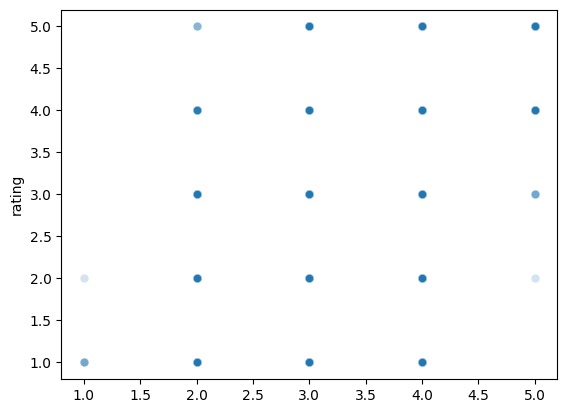

In [78]:
sns.scatterplot(x=test_preds.round(0), y=y_test, alpha=.1)